# Positive alpha trading strategy

>1. 总资产的50%用来做多，50%用来做空。  
>- 做空部分买3只股票，并使用Two-fund theorm，分离w1和w2。  
>- 确定w1和w2的组合比例，使w1与w2组合的Beta值与做多部分的股票Beta值相等。最终全部组合的Beta值为0。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import cvxpy
import re
import time
from urllib import request
#from pandas_datareader import DataReader
import yfinance as yf
warnings.simplefilter("ignore")

In [2]:
start = '2017-01-01'
end = time.strftime('%Y-%m-%d')

In [3]:
def download_data(tickers, start, end, path = 'data'):
    '''
    下载股票数据
    '''
    if not os.path.exists(path):
        os.mkdir(path)
    for ticker in tickers:
        #data = DataReader(ticker, 'yahoo', start=start, end=end)
        data = yf.Ticker(ticker).history(start=start, end=end)
        data.to_csv(path+'/'+ticker+'.csv')
        print('{:<15}\tlength:{}'.format(ticker, len(data)))
    print('Done!')

In [4]:
def get_beta(tickers, path='data',pr=True):
    '''
    爬取股票Beta值
    '''
    beta=[]
    url = 'https://finance.yahoo.com/quote/'
    for ticker in tickers:
        content = request.urlopen(url+ticker).read().decode("utf-8")
        reg = re.compile(r'data-reactid="62">(.*?)</span></td></tr><tr', re.S)
        b = float(re.findall(reg, content)[0])
        beta.append(b)
        # print('{:<15}\t{}'.format(ticker, b))
    return np.array(beta)

In [5]:
tickers = ['AMD', 'STX', 'INTC','TSLA','AAPL','NVDA','SNE','AMZN', 'FB', 'GOOG','BABA','JD','WB','NTES','TWTR']
download_data(tickers, start, end)

AMD            	length:621
STX            	length:621
INTC           	length:621
TSLA           	length:621
AAPL           	length:621
NVDA           	length:621
SNE            	length:621
AMZN           	length:621
FB             	length:621
GOOG           	length:621
BABA           	length:621
JD             	length:621
WB             	length:621
NTES           	length:621
TWTR           	length:621
Done!


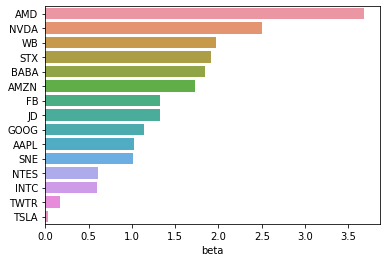

In [6]:
beta = get_beta(tickers)
beta_pd = pd.DataFrame(beta,index=tickers, columns=['beta']).sort_values('beta',ascending=False).T
beta_pd.to_csv('data/beta.csv')
sns.barplot(beta_pd.loc['beta',:], beta_pd.columns)

In [5]:
beta_pd = pd.read_csv('data/beta.csv',index_col=0)
beta_pd

,AMD,NVDA,WB,STX,BABA,AMZN,FB,JD,GOOG,AAPL,SNE,NTES,INTC,TWTR,TSLA
beta,3.68,2.5,1.97,1.91,1.85,1.73,1.33,1.32,1.14,1.03,1.01,0.61,0.6,0.17,0.03


# 投资组合：
买入：Sony（SNE）  
卖空：Intel（INTC）、网易（NTES）、Facebook（FB）

In [6]:
tickers_long = ['SNE']
tickers_short = ['INTC', 'NTES', 'FB']

## 卖空的组合

In [7]:
tickers_pd = pd.DataFrame()
for t in tickers_short:
    tickers_pd[t]=pd.read_csv('data/'+t+'.csv',index_col='Date')['Close']
tickers_pd.head()

,INTC,NTES,FB
Date,,,
2017-01-03,34.29,212.95,116.86
2017-01-04,34.11,213.48,118.69
2017-01-05,34.06,223.74,120.67
2017-01-06,34.18,221.54,123.41
2017-01-09,34.30,229.29,124.90


In [8]:
tickers_pcf = tickers_pd.pct_change().dropna()
tickers_pcf.head()

,INTC,NTES,FB
Date,,,
2017-01-04,-0.005249,0.002489,0.015660
2017-01-05,-0.001466,0.048061,0.016682
2017-01-06,0.003523,-0.009833,0.022707
2017-01-09,0.003511,0.034982,0.012074
2017-01-10,-0.002041,0.021632,-0.004404


In [9]:
sigma = tickers_pcf.cov()
sigma # 协方差矩阵

,INTC,NTES,FB
INTC,0.000300,0.000119,0.000121
NTES,0.000119,0.000590,0.000141
FB,0.000121,0.000141,0.000362


In [10]:
P = sigma.values
rr = tickers_pcf.mean().values
ee = np.ones(3)
inv_P=np.linalg.inv(P)
cee=np.dot(np.dot(ee.T,inv_P),ee)
cer=np.dot(np.dot(rr.T,inv_P),ee)

In [11]:
v1=np.dot(inv_P,ee)
w1=v1/cee
v2=np.dot(inv_P,rr)
w2=v2/cer
print(w1, w2)

[0.48433405 0.17221495 0.343451  ] [0.33697595 0.08010919 0.58291486]


In [12]:
beta_original = beta_pd[tickers_pd.columns]
beta_original

,INTC,NTES,FB
beta,0.6,0.61,1.33


In [13]:
beta_long = beta_pd[tickers_long[0]].values
beta1 = np.dot(w1, beta_original.T)
beta2 = np.dot(w2, beta_original.T)
print('做多股票的Beta：{}\n组合V1的Beta：{}\n组合V2的Beta：{}'.format(beta_long, beta1, beta2))

做多股票的Beta：[1.01]
组合V1的Beta：[0.85244138]
组合V2的Beta：[1.02632894]


In [14]:
x = cvxpy.Variable(1)
loss = cvxpy.abs(x*beta1+(1-x)*beta2-beta_long)
prob = cvxpy.Problem(cvxpy.Minimize(loss))
prob.solve()
x.value

array([0.09390516])

In [15]:
beta_short = x.value*beta1+(1-x.value)*beta2

In [16]:
print('做多股票Beta：{}\n做空组合Beta：{}'.format(beta_long, beta_short))

做多股票Beta：[1.01]
做空组合Beta：[1.01]


In [17]:
short_w = x.value*w1+(1-x.value)*w2
print('做空组合权重：',short_w)

做空组合权重： [0.35081364 0.0887584  0.56042797]


# 最终Positive Alpha策略组合

In [18]:
print('买入：{:6}\t50.00%'.format(tickers_long[0]))
for t, w in zip(tickers_short, short_w):
    print('卖空：{:6}\t{:.2f}%'.format(t,w*50))

买入：SNE   	50.00%
卖空：INTC  	17.54%
卖空：NTES  	4.44%
卖空：FB    	28.02%


# 组合收益表现

In [19]:
short_w

array([0.35081364, 0.0887584 , 0.56042797])

In [20]:
tickers_long_pcf = pd.read_csv('data/'+tickers_long[0]+'.csv',index_col='Date')['Close'].pct_change().dropna()

In [21]:
daily_return = 0.5*tickers_long_pcf-np.dot(short_w, tickers_pcf.T)*0.5
print('组合日平均收益率:',daily_return.mean())

组合日平均收益率: 0.0001799056443257842


Text(0.5, 0, 'Daily average yield distribution')

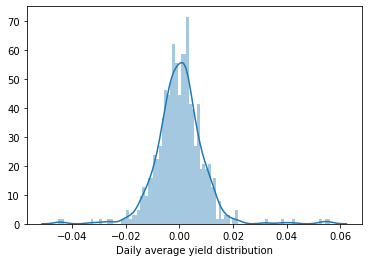

In [22]:
sns.distplot(daily_return, bins=100)
plt.xlabel('Daily average yield distribution')

In [23]:
gspc = yf.Ticker('^GSPC').history(start=start, end=end)['Close']  # 获取标普500指数
gspc_f =  gspc/gspc[0]

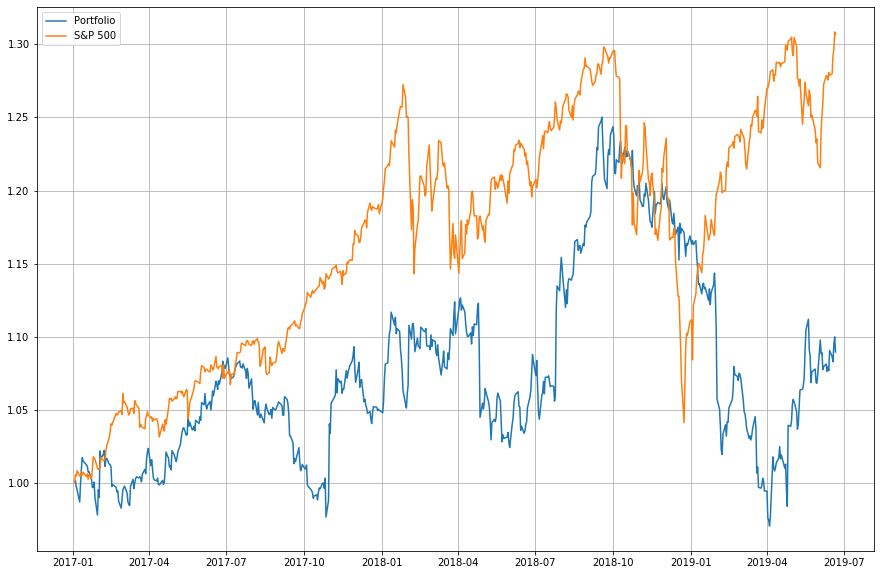

In [24]:
plt.figure(figsize=(15,10))
plt.plot(pd.to_datetime(tickers_pcf.index.values), np.cumprod(daily_return+1), label='Portfolio')
plt.plot(gspc_f, label='S&P 500')
plt.grid()
plt.legend()

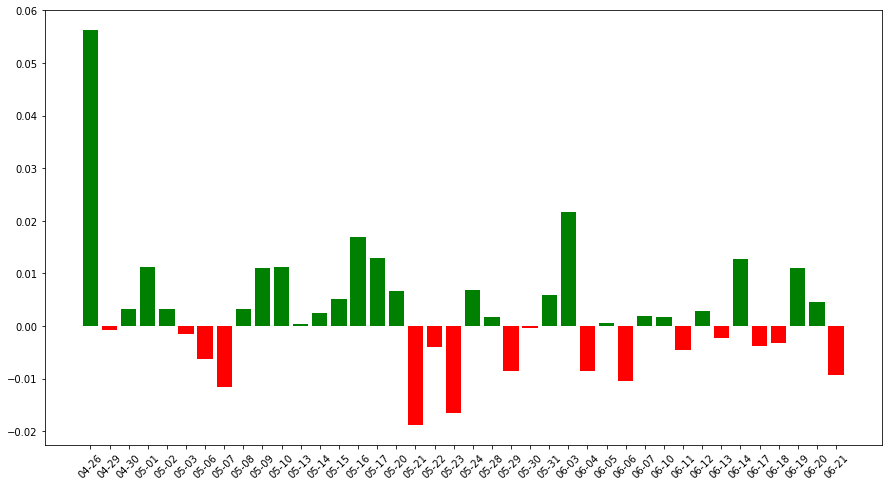

In [25]:
plt.figure(figsize=(15,8))
color = []
n=40
for i in daily_return[-n:]:
    if i>0:
        color.append('g')
    else:
        color.append('r')
plt.bar([i[-5:] for i in tickers_pcf.index.values[-n:]], daily_return[-n:], color=color)
plt.xticks(rotation=45)
plt.show()